In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u
from imp import reload
import scipy.optimize
import mla.core
import mla.injection
import mla.spectral
import warnings
import numpy.lib.recfunctions as rf
warnings.filterwarnings("ignore")
from skylab.ps_llh import PointSourceLLH
from skylab.llh_models import PowerLawLLH,EnergyLLH,ClassicLLH
from skylab.ps_injector import PointSourceInjector
import logging
skylab_logger = logging.getLogger('skylab')
skylab_logger.setLevel(logging.CRITICAL)

import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
exp = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
mc = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
exp['angErr'][exp['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
mc['angErr'][mc['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

exp['ra']=np.random.uniform(0,2*np.pi,size=len(exp))
grl = np.load("/data/i3store/users/mjlarson/student_data/GRL/IC86_2012_exp.npy")
livetime = np.sum(grl['livetime'])
exp=rf.append_fields(exp.copy(),
                           'sigma',
                           exp['angErr'],
                           dtypes=np.float32,usemask = False)
mc=rf.append_fields(mc.copy(),
                           'sigma',
                           mc['angErr'],
                           dtypes=np.float32,usemask = False)
exp=rf.append_fields(exp.copy(),
                           'sinDec',
                           np.sin(exp['dec']),
                           dtypes=np.float32,usemask = False)
mc=rf.append_fields(mc.copy(),
                           'sinDec',
                           np.sin(mc['dec']),
                           dtypes=np.float32,usemask = False)


Bad key "text.kerning_factor" on line 4 in
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/data/disk01/home/jasonfan/threeML/threeML/__init__.py:12: UserWarning: No DISPLAY variable set. Using backend for graphics without display (Agg)
  warnings.warn("No DISPLAY variable set. Using backend for graphics without display (Agg)")
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of K to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/paramet

In [2]:
"""
Setting up the model
"""
ra=np.radians(83.63)
dec=np.radians(22.0145)
inj = PointSourceInjector(gamma = 2., E0 = 1000.)
inj.fill(dec, exp, mc, livetime)

testskylab_model=EnergyLLH(twodim_bins=100)#twodim_bins=100)
#testskylab_model=ClassicLLH()
testskylab=PointSourceLLH.upscale(exp,mc,(livetime,100),testskylab_model,seed=1)
testskylab.fit_source(ra,dec)

(0.0, {'nsignal': 0.0, 'gamma': 2.467278692488895})

In [34]:
"""
Inject 30 signal events to test
"""
ni,sample =  inj.sample(src_ra=ra, mean_signal=30, poisson=False)
sample['time']=1
testskylab.pseudo_experiment(inject=sample)
a=testskylab.fit_source(ra,dec)
a

(166.87070649252414,
 {'nsignal': 33.374275235269224, 'gamma': 2.1115608401034267})

In [76]:
"""
Setting up mla, notice it will drop the events with zero singal spatial pdf unless setting fit_position = True
"""
reload(mla.core)
reload(mla)
testmla=mla.core.LLH_point_source(ra ,dec , exp[:5] , mc, "PowerLaw", background = exp , \
                              gamma_points = np.arange(-4, -1, 0.1),background_time_profile = (56224,56324),fit_position=False)


In [77]:
testdata = testskylab._exp
testdata['time'] = 56225 #Since I set a time profile between 56224 to 56324 
testmla.update_data(testdata)
#testmla.update_energy_weight(gamma=-2)

useless=testmla.eval_llh_fit()
#testmla.eval_llh_fit_ns()
testmla.get_fit_result()

(nan, nan, nan)

In [45]:
len(testdata)

34012

In [59]:
np.argwhere(np.around(np.arange(-4, -1, 0.1),2) == -2.0 )

array([[20]])

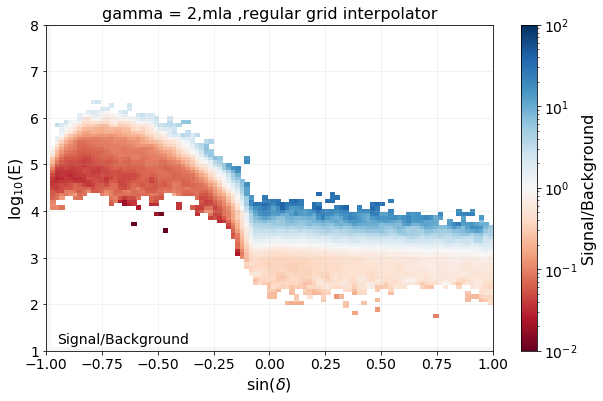

In [79]:
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
mlaratio = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        mlaratio[i][j] = np.exp(testmla.ratio[20]([sindec[i],logE[j]]))
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), mlaratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,mla ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)
np.save("mla_ratio.npy",mlaratio.T)

In [80]:
mlaratio.T

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., nan, nan, ..., nan, nan,  1.],
       [ 1., nan, nan, ..., nan, nan,  1.],
       ...,
       [ 1., nan, nan, ..., nan, nan,  1.],
       [ 1., nan, nan, ..., nan, nan,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [31]:
in_ns

array([ 1.        ,  1.39393939,  1.78787879,  2.18181818,  2.57575758,
        2.96969697,  3.36363636,  3.75757576,  4.15151515,  4.54545455,
        4.93939394,  5.33333333,  5.72727273,  6.12121212,  6.51515152,
        6.90909091,  7.3030303 ,  7.6969697 ,  8.09090909,  8.48484848,
        8.87878788,  9.27272727,  9.66666667, 10.06060606, 10.45454545,
       10.84848485, 11.24242424, 11.63636364, 12.03030303, 12.42424242,
       12.81818182, 13.21212121, 13.60606061, 14.        , 14.39393939,
       14.78787879, 15.18181818, 15.57575758, 15.96969697, 16.36363636,
       16.75757576, 17.15151515, 17.54545455, 17.93939394, 18.33333333,
       18.72727273, 19.12121212, 19.51515152, 19.90909091, 20.3030303 ,
       20.6969697 , 21.09090909, 21.48484848, 21.87878788, 22.27272727,
       22.66666667, 23.06060606, 23.45454545, 23.84848485, 24.24242424,
       24.63636364, 25.03030303, 25.42424242, 25.81818182, 26.21212121,
       26.60606061, 27.        , 27.39393939, 27.78787879, 28.18

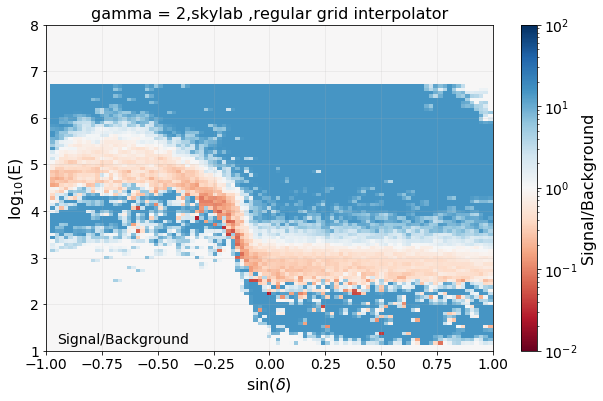

In [65]:
events = testskylab._exp[:10000]
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
n=0
for i in range(100):
    for j in range(100):
        events[n]['sinDec']=sindec[i]
        events[n]['logE']=logE[j]
        n+=1
        

e, _ = testskylab.llh_model.weight(events, gamma=2.0)        # energy s/b with fit gamma. Fixed in Liz's analysis to 2.0
ratio=np.reshape(e,(100,100))
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,skylab ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)


ValueError: operands could not be broadcast together with shapes (99,99) (100,100) 

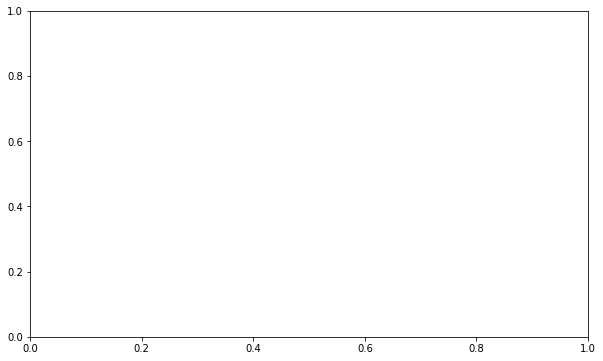

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T - mlaratio.T,
                     cmap = 'RdBu',
                     vmin = 15,
                     vmax = -15)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,skylab-mla", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [63]:
(ratio.T - mlaratio.T).max()

15.058493180452686

In [81]:
data = exp
sim = mc
gamma = -2
bins=[np.linspace(-1,1,100),np.linspace(1,8,100)]
r'''create the S/B ratio 2d spline for a given gamma.
args:
data: Background data
sim: Monte Carlo Simulation dataset
gamma: spectral index
bins: Bins defination,first one is sinDec binning and the second one is logE binning.

returns:
spline,bins:The S/B energy spline and the binning. 
'''
# background
r'''create the S/B ratio 2d spline for a given gamma.
args:
data: Background data
sim: Monte Carlo Simulation dataset
gamma: spectral index
bins: Bins defination,first one is sinDec binning and the second one is logE binning.

returns:
spline,bins:The S/B energy spline and the binning. 
'''
# background
bins = np.array(bins)
bg_w = np.ones(len(data), dtype=float)
bg_w /= np.sum(bg_w)
bg_h, xedges, yedges  = np.histogram2d(np.sin(data['dec']),
                                       data['logE'],
                                       bins=bins,
                                       weights = bg_w)

# signal
sig_w = sim['ow'] * sim['trueE']**gamma
sig_w /= np.sum(sig_w)
sig_h, xedges, yedges = np.histogram2d(np.sin(sim['dec']),
                                       sim['logE'],
                                       bins=bins,
                                       weights = sig_w)

ratio = sig_h / bg_h
for i in range(ratio.shape[0]):
    # Pick out the values we want to use.
    # We explicitly want to avoid NaNs and infinities
    values = ratio[i]
    good = np.isfinite(values) & (values>0)
    notgood = np.logical_not(good)
    x, y = bins[1][:-1][good], values[good]

    # Do a linear interpolation across the energy range
    spline = scipy.interpolate.UnivariateSpline(x, y,
                                                k = 1,
                                                s = 0,
                                                ext = 1)

    # And store the interpolated values
    #ratio[i][notgood] = spline(bins[1,:-1][notgood])
    ratio[i][notgood] = np.percentile((ratio[np.isfinite(ratio) & (ratio>0)]),99)

binsmid0 = (bins[0][1:] + bins[0][:-1]) / 2    
binsmid1 = (bins[1][1:] + bins[1][:-1]) / 2    
spline = scipy.interpolate.RegularGridInterpolator(
        (binsmid0,binsmid1), np.log(ratio),
        method="linear",
        bounds_error=False,
        fill_value=0.)

In [82]:
ratio

41.53967255781285

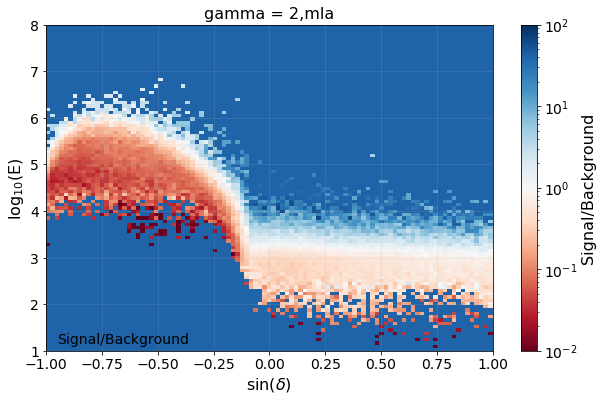

In [83]:
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,mla", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)